# Find the best few-shot examples using simulation-based inference

In [1]:
import json
import random
import requests
import re

import outlines.models as models
import outlines.text as text

random.seed(0)

In [18]:
%env OPENAI_API_KEY = # your key here

env: OPENAI_API_KEY=# your key here


In this example we will use GPT 3.5 to solve problems from the GSM-8K dataset. The state-of-the-art performance on this dataset is obtained using few-shot prompting with 5 examples. However, it is not clear how one should select these examples. Here, we will use **simulation-based inference** to try to infer which examples we should be using to get the best out of the model's abilities to solve the problem.

Let's start with downloading the dataset:

In [3]:
result = requests.get("https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/train.jsonl")
lines = result.iter_lines()

We now divide the train set in two sets:
- 20 problems from which we are going to sample 5 examples at random for every inference;
- 500 problems which we are going to use to perform inference.

In [4]:
example_set = []
for _ in range(10):
    line = json.loads(next(lines))
    answer = re.findall(r"\d+", line["answer"])[-1]
    example_set.append({"question": line["question"], "answer": answer})

train_set = []
for _ in range(500):
    line = json.loads(next(lines))
    answer = re.findall(r"\d+", line["answer"])[-1]
    train_set.append({"question": line["question"], "answer": answer})

Now let's define the prompt, the model, and the sampling loop. The sampling loop consists in choosing 5 examples at random, sampling 20 model answers; if the answer is correct we keep the example ids as samples, otherwise continue:

In [9]:
@text.prompt
def few_shots(question, examples):
    """
    {% for example in examples %}
    Q: {{ example.question }}
    A: {{ example.answer }}
    {% endfor %}
    Q: {{ question }}
    A:
    """

model = models.text_completion.openai("text-davinci-003", max_tokens=128)

# TODO: This could largely benefit from vectorization in #52
def one_train_example(problem, example_set):
    example_ids = random.choices(range(0, len(example_set)), k=5)
    examples = [example_set[i] for i in example_ids]
    prompt = few_shots(problem["question"], examples)
    answers_raw = model(prompt, samples=20)

    samples = []
    for answer_raw in answers_raw:
        try:
            answer = re.findall(r"\d+", answer_raw)[-1]
            if answer == problem["answer"]:
                samples += example_ids
            else:
                continue
        except IndexError:
            pass

    return samples

In [10]:
from tqdm.contrib import tenumerate

samples = []
for i, train_example in tenumerate(train_set):
    samples += one_train_example(train_example, example_set)

  0%|          | 0/500 [00:00<?, ?it/s]

We can now plot the number of times each example was sampled:

Text(0, 0.5, 'Counts')

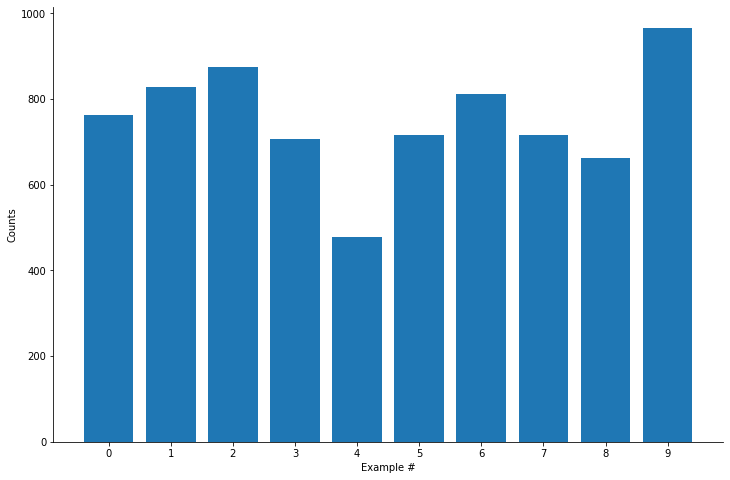

In [11]:
import numpy as np
import matplotlib.pylab as plt

example_ids, counts = np.unique(samples, return_counts=True)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.bar(example_ids, counts)

ax.spines[["top", "right"]].set_visible(False)

ax.set_xticks(range(10))
ax.set_xlabel("Example #")
ax.set_ylabel("Counts")


Looking at the distribution, our best guess for which examples we should use for benchmarking on the test set would be 0, 1, 2, 6 and 9. This method can be trivially extended to other workflows that use few-shot examples to query LLMs. Of course, simulation-based inference extends beyong choosing the "best" prompt, and could for instance be useful to select the structure of chains of LLMs and tools as well.

In [13]:
example_set[0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': '72'}

In [14]:
example_set[1]

{'question': 'Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?',
 'answer': '10'}

In [15]:
example_set[2]

{'question': 'Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?',
 'answer': '5'}

In [16]:
example_set[6]

{'question': 'Albert is wondering how much pizza he can eat in one day. He buys 2 large pizzas and 2 small pizzas. A large pizza has 16 slices and a small pizza has 8 slices. If he eats it all, how many pieces does he eat that day?',
 'answer': '48'}

In [17]:
example_set[9]

{'question': 'Tina makes $18.00 an hour.  If she works more than 8 hours per shift, she is eligible for overtime, which is paid by your hourly wage + 1/2 your hourly wage.  If she works 10 hours every day for 5 days, how much money does she make?',
 'answer': '990'}